In [3]:
%load_ext autoreload
%autoreload 2

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

from tqdm import tqdm
import json

from datetime import datetime
import functools
import matplotlib.pyplot as plt
import numpy as np

from datasets.shapenet_data_pc import ShapeNet15kPointClouds
from models_adl4cv.pvcnn import PVCNNUpPointAttention
from models_adl4cv.loss import get_repulsion_loss4
from models_adl4cv.patching import get_nearest_neighbors_batch_pytorch3d, generate_non_overlapping_patches

from metrics.ChamferDistancePytorch.chamfer_python import distChamfer
from metrics.PyTorchEMD.emd import earth_mover_distance as EMD

from visuals.visuals_util import rotate_point_cloud_x, rotate_point_cloud_z, rotate_point_cloud_y, visualize_pointcloud_eval, save_fig, visualize_pointcloud_eval_three, visualize_pointcloud

# Prepare Datasets and DataLoaders

In [10]:
NPOINTS = 2048 * 3
CATEGORY = "airplane"
BATCH_SIZE = 8 * 3
PATCH_SIZE = 512

In [11]:
tr_dataset = ShapeNet15kPointClouds(root_dir="./ShapeNetCore.v2.PC15k",
    categories=[CATEGORY], split='train',
    tr_sample_size=NPOINTS,
    te_sample_size=NPOINTS,
    scale=1.,
    normalize_per_shape=False,
    normalize_std_per_axis=False,
    random_subsample=True)

val_dataset = ShapeNet15kPointClouds(root_dir="./ShapeNetCore.v2.PC15k",
    categories=[CATEGORY], split='val',
    tr_sample_size=NPOINTS,
    te_sample_size=NPOINTS,
    scale=1.,
    normalize_per_shape=False,
    normalize_std_per_axis=False,
    random_subsample=True)

test_dataset = ShapeNet15kPointClouds(root_dir="./ShapeNetCore.v2.PC15k",
    categories=[CATEGORY], split='test',
    tr_sample_size=NPOINTS,
    te_sample_size=NPOINTS,
    scale=1.,
    normalize_per_shape=False,
    normalize_std_per_axis=False,
    random_subsample=True)

Total number of data:2832
Min number of points: (train)6144 (test)5000
Total number of data:405
Min number of points: (train)6144 (test)5000
Total number of data:808
Min number of points: (train)6144 (test)5000


In [12]:
train_dataloader = torch.utils.data.DataLoader(tr_dataset, 
                                               batch_size=BATCH_SIZE, 
                                               sampler=None, 
                                               shuffle=True is None, 
                                               num_workers=1, 
                                               drop_last=True)

val_dataloader = torch.utils.data.DataLoader(val_dataset, 
                                               batch_size=BATCH_SIZE, 
                                               sampler=None, 
                                               shuffle=True is None, 
                                               num_workers=1, 
                                               drop_last=True)

test_dataloader = torch.utils.data.DataLoader(test_dataset, 
                                               batch_size=BATCH_SIZE, 
                                               sampler=None, 
                                               shuffle=True is None, 
                                               num_workers=1, 
                                               drop_last=True)

In [13]:
len(tr_dataset), len(val_dataset), len(test_dataset)

(2832, 405, 808)

In [14]:
def add_random_noise(point_cloud, mean=0, std=0.05):
    noise = torch.normal(mean, std, size=point_cloud.size()).to("cuda")
    point_cloud_noise = point_cloud + noise
    return point_cloud_noise

In [15]:
def chamfer_distance(a, b):
    min_dist_a_to_b, min_dist_b_to_a, _, _ = distChamfer(a, b)
    return (min_dist_a_to_b.mean() + min_dist_b_to_a.mean()) / 2

In [16]:
def EMD_loss(a,b):
    return EMD(a,b, transpose=False).mean()

In [17]:
def combined_loss(input, output):
    # Expects output of shape: [B, N, C]
    emd_loss = EMD_loss(input, output)
    repulsion_loss = get_repulsion_loss4(output)

    # Same as in https://github.com/yulequan/PU-Net/blob/master/code/model_utils.py
    return 10 * emd_loss + repulsion_loss

In [18]:
def subsample(pc, npoints=2048):
    # pc: [B, N, C] N <= npoints
    _, N, _ = pc.shape
    assert npoints <= N

    idx = np.random.choice(N, npoints)
    return pc[:,idx,:]

In [19]:
def subsample_patches(pc, npoints=2048):
    # pc: [P, B, N, C] N <= npoints
    _, _, N, _ = pc.shape
    assert npoints <= N

    idx = np.random.choice(N, npoints)
    return pc[:,:,idx,:]

In [191]:
model = PVCNNUpPointAttention(num_classes=3, num_shapes=0, extra_feature_channels=0, attention=True, attn_dim=256, up_ratio=2).to("cuda")
model

PVCNNUpPointAttention(
  (point_features): ModuleList(
    (0): PVConv(
      (voxelization): Voxelization(resolution=32)
      (voxel_layers): Sequential(
        (0): Conv3d(3, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): GroupNorm(8, 64, eps=1e-05, affine=True)
        (2): Swish()
        (3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (4): GroupNorm(8, 64, eps=1e-05, affine=True)
        (5): Swish()
        (6): SE3d(
          (fc): Sequential(
            (0): Linear(in_features=64, out_features=8, bias=False)
            (1): Swish()
            (2): Linear(in_features=8, out_features=64, bias=False)
            (3): Sigmoid()
          )
        )
      )
      (point_features): SharedMLP(
        (layers): Sequential(
          (0): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
          (1): GroupNorm(8, 64, eps=1e-05, affine=True)
          (2): Swish()
        )
      )
    )
    (1): PVConv(
      (vo

In [15]:
noise = torch.normal(0, 1, size=(BATCH_SIZE, 4096, 3))
subsampled_noise = subsample(noise)

print(noise.shape, subsampled_noise.shape)

noise = torch.normal(0, 1, size=(BATCH_SIZE, 4096, 3)).to("cuda")
noise_subsample = subsample(noise)

torch.Size([8, 4096, 3]) torch.Size([8, 2048, 3])


In [25]:
# Random patch
patched_input = get_nearest_neighbors_batch_pytorch3d(noise_subsample, 512).transpose(1,2)

patched_input.shape

torch.Size([8, 3, 512])

In [26]:
patched_input = generate_non_overlapping_patches(noise_subsample).transpose(2,3)
patched_input.shape

torch.Size([4, 8, 3, 512])

In [15]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

7929859

In [16]:
output = model(noise_subsample[:10, ...].transpose(1,2)).transpose(1,2)

noise.shape, output.shape

torch.Size([8, 4096, 3, 1])


(torch.Size([8, 4096, 3]), torch.Size([8, 4096, 3]))

In [17]:
emd_loss = EMD_loss(noise, output)
emd_loss

tensor(2.4672, device='cuda:0', grad_fn=<MeanBackward0>)

In [192]:
# TensorBoard Logging with model's name and current date
current_time = datetime.now().strftime('%b%d_%H-%M-%S')
model_name = 'PVCNN-Upsample-Global-Chair-Attention-Everywhere-Patch-Airplane-4k-New'
log_dir = f"runs/{model_name}_{current_time}"
writer = SummaryWriter(log_dir=log_dir)

LEARNING_RATE_CLIP = 1e-5
DECCAY_STEP = 5
LEARNING_RATE = 1e-3
LEARNING_RATE_DECAY = 0.5

# Optimization
optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-4)

# Losses
training_losses = []
val_losses = []

# Early Stopping (patience)
best_val_loss = np.inf
patience = 10
patience_counter = 0

In [193]:
for epoch in range(100):
    total_train_loss = 0
    total_val_loss = 0
    
    # Point Transformer Learning Rate Scheduling
    lr = max(LEARNING_RATE * (LEARNING_RATE_DECAY ** (epoch // DECCAY_STEP)), LEARNING_RATE_CLIP)
    print('Learning rate:%f' % lr)

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    # Train
    model.train()
    with tqdm(train_dataloader, desc=f'Epoch {epoch+1}/100 Training') as tbar:
        for batch in tbar:
            input = batch["train_points"].to("cuda")

            # Select a random patch with double the size, then downsample, then add noise.
            patched_input = get_nearest_neighbors_batch_pytorch3d(input, PATCH_SIZE * 2)
            input_downsampled = subsample(patched_input, npoints=PATCH_SIZE)
            noised_downsampled_patches = add_random_noise(input_downsampled).transpose(1,2)

            optimizer.zero_grad()
            output = model(noised_downsampled_patches).to("cuda").transpose(1,2)

            loss = combined_loss(patched_input, output)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            tbar.set_postfix(loss=total_train_loss / (tbar.n + 1))

    epoch_train_loss = total_train_loss / len(train_dataloader)
    training_losses.append(epoch_train_loss)

    # Validate
    model.eval()
    with torch.no_grad(), tqdm(val_dataloader, desc=f'Epoch {epoch+1}/100 Validating') as tbar:
        for batch in tbar:
            input = batch["train_points"].to("cuda")

            # Select a random patch with double the size, then downsample, then add noise.
            patched_input = get_nearest_neighbors_batch_pytorch3d(input, PATCH_SIZE * 2)
            input_downsampled = subsample(patched_input, npoints=PATCH_SIZE)
            noised_downsampled_patches = add_random_noise(input_downsampled).transpose(1,2)

            output = model(noised_downsampled_patches).to("cuda").transpose(1,2)

            val_loss = combined_loss(patched_input, output)
            total_val_loss += val_loss.item()
            tbar.set_postfix(loss=total_val_loss / (tbar.n + 1))

    epoch_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(epoch_val_loss)

    writer.add_scalar('Loss/train', epoch_train_loss, epoch)
    writer.add_scalar('Loss/val', epoch_val_loss, epoch)

    print(json.dumps({"Epoch": epoch+1, "Training Loss": epoch_train_loss, "Validation Loss": epoch_val_loss}))

    # Save the model
    model_save_path = f"output-models/pvcnn-upsample-global-chair/PVCNN-Upsample-Global-Chair-Attention-Everywhere-Patch-Airplane-4k-New-e{epoch+1}.pth"
    torch.save(model.state_dict(), model_save_path)

    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"No improvement in validation loss for {patience_counter} epochs.")

    if patience_counter >= patience:
        print("Stopping early due to no improvement in validation loss.")
        break


writer.close()


Epoch 1/100 Training:   0%|          | 0/88 [00:00<?, ?it/s]

Learning rate:0.001000


Epoch 2/100 Training:   0%|          | 0/88 [00:00<?, ?it/s]

{"Epoch": 1, "Training Loss": 3.006746132942763, "Validation Loss": 0.9050076951583227}
Learning rate:0.001000


Epoch 3/100 Training:   0%|          | 0/88 [00:00<?, ?it/s]

{"Epoch": 2, "Training Loss": 1.0149768374182961, "Validation Loss": 0.9609547605117162}
No improvement in validation loss for 1 epochs.
Learning rate:0.001000


Epoch 4/100 Training:   0%|          | 0/88 [00:00<?, ?it/s]

{"Epoch": 3, "Training Loss": 0.8926871134476229, "Validation Loss": 0.8200847804546356}
Learning rate:0.001000


Epoch 5/100 Training:   0%|          | 0/88 [00:00<?, ?it/s]

{"Epoch": 4, "Training Loss": 0.8094894127412275, "Validation Loss": 0.9326919068892797}
No improvement in validation loss for 1 epochs.
Learning rate:0.001000


Epoch 6/100 Training:   0%|          | 0/88 [00:00<?, ?it/s]

{"Epoch": 5, "Training Loss": 0.8223890912803736, "Validation Loss": 0.7750370850165685}
Learning rate:0.000500


Epoch 7/100 Training:   0%|          | 0/88 [00:00<?, ?it/s]

{"Epoch": 6, "Training Loss": 0.716120144860311, "Validation Loss": 0.6887241105238596}
Learning rate:0.000500


Epoch 8/100 Training:   0%|          | 0/88 [00:00<?, ?it/s]

{"Epoch": 7, "Training Loss": 0.7217190225015987, "Validation Loss": 0.6973261137803396}
No improvement in validation loss for 1 epochs.
Learning rate:0.000500


Epoch 9/100 Training:   0%|          | 0/88 [00:00<?, ?it/s]

{"Epoch": 8, "Training Loss": 0.7027243504470045, "Validation Loss": 0.7345977276563644}
No improvement in validation loss for 2 epochs.
Learning rate:0.000500


Epoch 10/100 Training:   0%|          | 0/88 [00:00<?, ?it/s]

{"Epoch": 9, "Training Loss": 0.7559588666666638, "Validation Loss": 0.6970306088527044}
No improvement in validation loss for 3 epochs.
Learning rate:0.000500


Epoch 11/100 Training:   0%|          | 0/88 [00:00<?, ?it/s]

{"Epoch": 10, "Training Loss": 0.7049260593273423, "Validation Loss": 0.7112664729356766}
No improvement in validation loss for 4 epochs.
Learning rate:0.000250


Epoch 12/100 Training:   0%|          | 0/88 [00:00<?, ?it/s]

{"Epoch": 11, "Training Loss": 0.7155205695466562, "Validation Loss": 0.6277433981498083}
Learning rate:0.000250


Epoch 13/100 Training:   0%|          | 0/88 [00:00<?, ?it/s]

{"Epoch": 12, "Training Loss": 0.7042341855439272, "Validation Loss": 0.6432753950357437}
No improvement in validation loss for 1 epochs.
Learning rate:0.000250


Epoch 14/100 Training:   0%|          | 0/88 [00:00<?, ?it/s]

{"Epoch": 13, "Training Loss": 0.6868617622689768, "Validation Loss": 0.6781280636787415}
No improvement in validation loss for 2 epochs.
Learning rate:0.000250


Epoch 15/100 Training:   0%|          | 0/88 [00:00<?, ?it/s]

{"Epoch": 14, "Training Loss": 0.6942071095108986, "Validation Loss": 0.6744766632715861}
No improvement in validation loss for 3 epochs.
Learning rate:0.000250


Epoch 16/100 Training:   0%|          | 0/88 [00:00<?, ?it/s]

{"Epoch": 15, "Training Loss": 0.6801568466154012, "Validation Loss": 0.6165634642044703}
Learning rate:0.000125


Epoch 17/100 Training:   0%|          | 0/88 [00:00<?, ?it/s]

{"Epoch": 16, "Training Loss": 0.6551180678335103, "Validation Loss": 0.6973499655723572}
No improvement in validation loss for 1 epochs.
Learning rate:0.000125


Epoch 18/100 Training:   0%|          | 0/88 [00:00<?, ?it/s]

{"Epoch": 17, "Training Loss": 0.6879005960442803, "Validation Loss": 0.6595339427391688}
No improvement in validation loss for 2 epochs.
Learning rate:0.000125


Epoch 19/100 Training:   0%|          | 0/88 [00:00<?, ?it/s]

{"Epoch": 18, "Training Loss": 0.6572878807783127, "Validation Loss": 0.686240091919899}
No improvement in validation loss for 3 epochs.
Learning rate:0.000125


Epoch 20/100 Training:   0%|          | 0/88 [00:00<?, ?it/s]

{"Epoch": 19, "Training Loss": 0.685250229456208, "Validation Loss": 0.6527548183997472}
No improvement in validation loss for 4 epochs.
Learning rate:0.000125


Epoch 21/100 Training:   0%|          | 0/88 [00:00<?, ?it/s]

{"Epoch": 20, "Training Loss": 0.660366147079251, "Validation Loss": 0.6065859744946162}
Learning rate:0.000063


Epoch 22/100 Training:   0%|          | 0/88 [00:00<?, ?it/s]

{"Epoch": 21, "Training Loss": 0.6688121889125217, "Validation Loss": 0.6362321724494299}
No improvement in validation loss for 1 epochs.
Learning rate:0.000063


Epoch 23/100 Training:   0%|          | 0/88 [00:00<?, ?it/s]

{"Epoch": 22, "Training Loss": 0.6603994830088182, "Validation Loss": 0.6272076318661371}
No improvement in validation loss for 2 epochs.
Learning rate:0.000063


Epoch 24/100 Training:   0%|          | 0/88 [00:00<?, ?it/s]

{"Epoch": 23, "Training Loss": 0.6657223159616644, "Validation Loss": 0.621144250035286}
No improvement in validation loss for 3 epochs.
Learning rate:0.000063


Epoch 25/100 Training:   0%|          | 0/88 [00:00<?, ?it/s]

{"Epoch": 24, "Training Loss": 0.6682881103320555, "Validation Loss": 0.6730917990207672}
No improvement in validation loss for 4 epochs.
Learning rate:0.000063


Epoch 26/100 Training:   0%|          | 0/88 [00:00<?, ?it/s]

{"Epoch": 25, "Training Loss": 0.6636119153011929, "Validation Loss": 0.6494172414143881}
No improvement in validation loss for 5 epochs.
Learning rate:0.000031


Epoch 27/100 Training:   0%|          | 0/88 [00:00<?, ?it/s]

{"Epoch": 26, "Training Loss": 0.6766565448858521, "Validation Loss": 0.7061562339464823}
No improvement in validation loss for 6 epochs.
Learning rate:0.000031


Epoch 28/100 Training:   0%|          | 0/88 [00:00<?, ?it/s]

{"Epoch": 27, "Training Loss": 0.6680575263771144, "Validation Loss": 0.6268247465292612}
No improvement in validation loss for 7 epochs.
Learning rate:0.000031


Epoch 29/100 Training:   0%|          | 0/88 [00:00<?, ?it/s]

{"Epoch": 28, "Training Loss": 0.6692874336784537, "Validation Loss": 0.6710512538750967}
No improvement in validation loss for 8 epochs.
Learning rate:0.000031


Epoch 30/100 Training:   0%|          | 0/88 [00:00<?, ?it/s]

{"Epoch": 29, "Training Loss": 0.6645016758279367, "Validation Loss": 0.6441739996274313}
No improvement in validation loss for 9 epochs.
Learning rate:0.000031


Epoch 30/100 Validating: 100%|██████████| 12/12 [00:02<00:00,  4.22it/s, loss=0.652]

{"Epoch": 30, "Training Loss": 0.652656767855991, "Validation Loss": 0.6520454237858454}
No improvement in validation loss for 10 epochs.
Stopping early due to no improvement in validation loss.


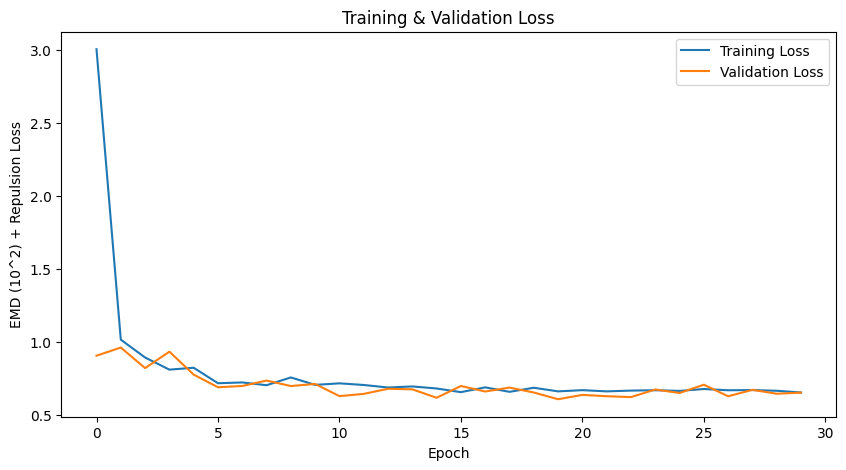

In [194]:
plt.figure(figsize=(10, 5))
plt.plot(training_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('EMD (10^2) + Repulsion Loss')
plt.legend()
plt.show()

torch.Size([4096, 3]) torch.Size([512, 3]) torch.Size([1024, 3])


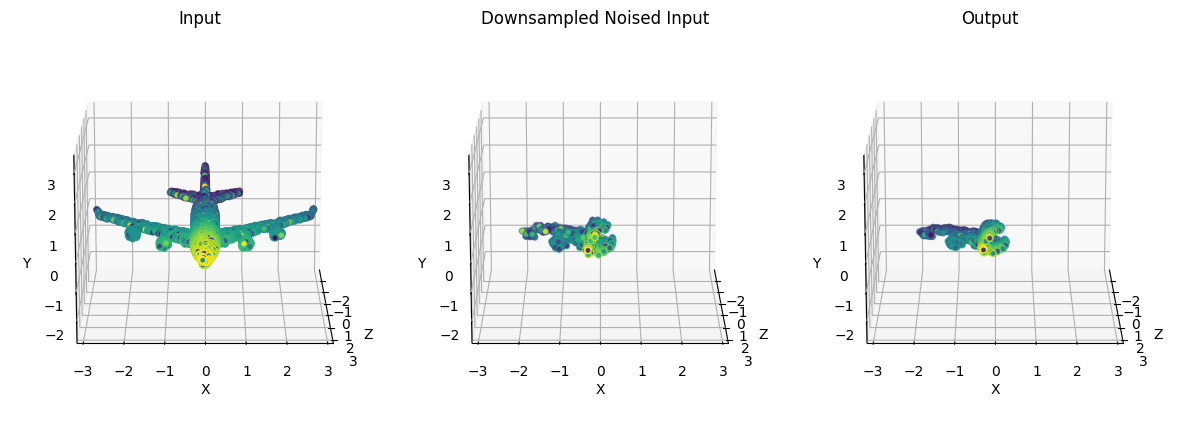

In [20]:
INDEX = 0
input_pc = input[INDEX, ...].detach()
noised_input_pc = noised_downsampled_patches[INDEX, ...].detach().transpose(0,1)
output_pc = output[INDEX, ...].detach()
print(input_pc.shape, noised_input_pc.shape, output_pc.shape)

fig = visualize_pointcloud_eval_three(input_pc, noised_input_pc, output_pc, 
                                "Input", "Downsampled Noised Input", "Output")

# Let's visualize some examples

In [20]:
# Run this if you need to load the model.

model = PVCNNUpPointAttention(num_classes=3, num_shapes=0, extra_feature_channels=0, attention=True, attn_dim=256, up_ratio=3).to("cuda")
model.load_state_dict(torch.load("output-models/pvcnn-upsample-global-chair/PVCNN-Upsample-Global-Chair-Attention-Everywhere-Patch-Airplane-6k-New-e48.pth"))

<All keys matched successfully>

# Evaluate the trained PVCNN

In [26]:
model.eval()

total_test_loss = 0

input_arr = []
output_arr = []

for i, batch in enumerate(test_dataloader):
    with torch.no_grad():
        input = batch["train_points"].to("cuda")

        # Select a random patch with double the size, then downsample, then add noise.
        patched_input = generate_non_overlapping_patches(input, PATCH_SIZE * 2)
        input_downsampled = subsample_patches(patched_input, npoints=PATCH_SIZE)
        noised_downsampled_patches = add_random_noise(input_downsampled).transpose(2,3)
        
        refined_patches = []
        for patch in noised_downsampled_patches:
            output = model(patch).to("cuda").transpose(1,2)
            refined_patches.append(output)
        
        output = torch.stack(refined_patches).transpose(0,1).reshape(BATCH_SIZE, NPOINTS, 3)
        input_arr.append(input)
        output_arr.append(output)

        loss = combined_loss(input, output)
        total_test_loss += loss.item()
        print(f"Batch {i}, EMD + Repulsion Loss: {loss.item():.4f}")

average_loss = total_test_loss / len(test_dataloader)
print(f"TOTAL CD Loss: {average_loss:.4f}")

torch.Size([32, 6144, 3])
Batch 0, EMD + Repulsion Loss: 0.9396


KeyboardInterrupt: 

In [22]:
noised_downsampled_patches_comb = noised_downsampled_patches.transpose(0,1).transpose(2,3).reshape(BATCH_SIZE, NPOINTS // 2, 3)
noised_downsampled_patches_comb.shape

torch.Size([32, 2048, 3])

torch.Size([4096, 3]) torch.Size([2048, 3]) torch.Size([4096, 3])


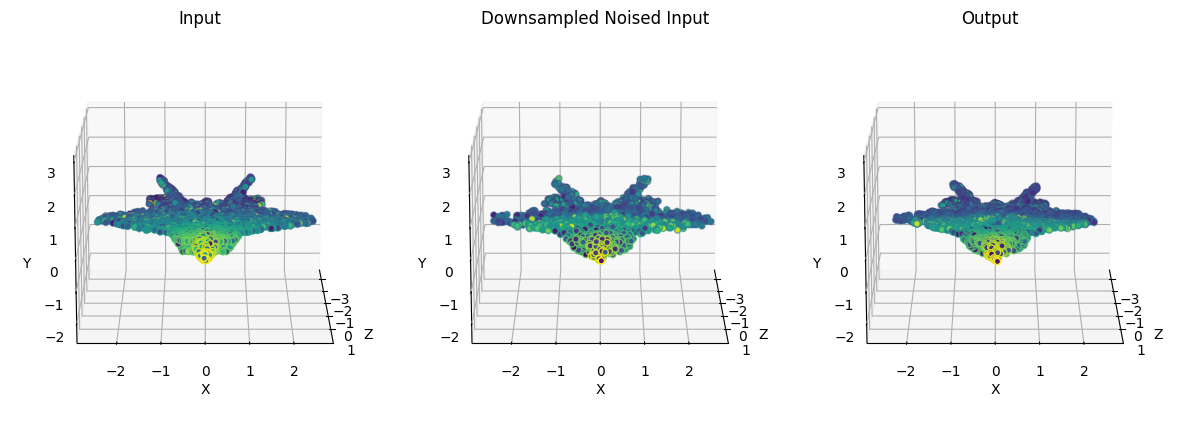

In [30]:
INDEX = 6
input_pc = input[INDEX, ...].detach()
noised_input_pc = noised_downsampled_patches_comb[INDEX, ...].detach()
output_pc = output[INDEX, ...].detach()
print(input_pc.shape, noised_input_pc.shape, output_pc.shape)

fig = visualize_pointcloud_eval_three(input_pc, noised_input_pc, output_pc, 
                                "Input", "Downsampled Noised Input", "Output")

# Let's now try to imrpove the dataset of PVD

In [21]:
from datasets.pvd_data_pc import ShapeNet15kPointCloudsPVD

dataset_pvd = ShapeNet15kPointCloudsPVD(root_dir="./custom-dataset",
    categories=[CATEGORY], split='train',
    tr_sample_size=2048,
    te_sample_size=2048,
    scale=1.,
    normalize_per_shape=False,
    normalize_std_per_axis=False,
    random_subsample=True)

dataloader_pvd = torch.utils.data.DataLoader(dataset_pvd, 
                                               batch_size=20, 
                                               sampler=None, 
                                               shuffle=True is None, 
                                               num_workers=1, 
                                               drop_last=True)

final_val_dataloader = torch.utils.data.DataLoader(val_dataset, 
                                               batch_size=20, 
                                               sampler=None, 
                                               shuffle=True is None, 
                                               num_workers=1, 
                                               drop_last=True)

Total number of data:400
Min number of points: (train)2048 (test)2048


In [22]:
input_array = []

for batch in final_val_dataloader:
    input = batch["test_points"].to("cuda")
    input_array.append(input)

In [23]:
from models_adl4cv.patching import non_overlapping_spectral_patches_batch

test_input = non_overlapping_spectral_patches_batch(input)
test_input

graph not connected for 10 increasing it to 20 to connect the graph
graph not connected for 20 increasing it to 40 to connect the graph


graph not connected for 10 increasing it to 20 to connect the graph


graph not connected for 10 increasing it to 20 to connect the graph
graph not connected for 20 increasing it to 40 to connect the graph


graph not connected for 10 increasing it to 20 to connect the graph


graph not connected for 10 increasing it to 20 to connect the graph


graph not connected for 10 increasing it to 20 to connect the graph
graph not connected for 20 increasing it to 40 to connect the graph


graph not connected for 10 increasing it to 20 to connect the graph


graph not connected for 10 increasing it to 20 to connect the graph


graph not connected for 10 increasing it to 20 to connect the graph


[[tensor([[-0.8407, -0.4674, -0.8495],
          [-1.2386, -0.2048,  0.2932],
          [-1.0165, -0.2227,  0.2143],
          ...,
          [-0.7964, -0.3537, -0.3840],
          [-0.9994, -0.3156, -0.0541],
          [-0.6433, -0.2711, -0.2369]], device='cuda:0'),
  tensor([[-3.1047e-01, -1.6578e-04,  5.2726e-01],
          [ 2.4044e-01, -2.7368e-01, -6.4542e-01],
          [-2.7226e-01,  1.4660e-01,  2.2644e-01],
          ...,
          [-2.7035e-01, -2.8582e-01, -1.7120e-01],
          [-2.9094e-01,  1.0522e-01, -2.4169e-01],
          [ 2.7429e-01, -2.0345e-01,  2.1426e-01]], device='cuda:0'),
  tensor([[ 6.1604e-01, -4.8985e-01, -3.7285e-02],
          [ 4.8483e-01, -5.2202e-01, -5.6335e-02],
          [ 5.5481e-01, -4.6630e-01,  1.0210e-01],
          [ 4.0966e-01, -4.4267e-01,  2.7939e-02],
          [ 4.0933e-01, -5.5367e-01, -5.4856e-02],
          [ 5.5481e-01, -4.6630e-01,  1.0210e-01],
          [ 5.2265e-01, -4.7055e-01,  7.5409e-02],
          [ 4.2194e-01, -4.0752e-01

In [24]:
model.eval()

pvd_output = []
output_array = []
for batch in tqdm(dataloader_pvd):
    with torch.no_grad():
        input = batch["train_points"].to("cuda")
        pvd_output.append(input)

        # # Select a random patch with double the size, then downsample, then add noise.
        # patched_input = generate_non_overlapping_patches(input, PATCH_SIZE).transpose(2,3)
        # refined_patches = []
        # for patch in patched_input:
        #     output = model(patch).to("cuda").transpose(1,2)
        #     refined_patches.append(output)
        
        patched_input = non_overlapping_spectral_patches_batch(input)
        refined_patches = []
        for sample in patched_input:
            for patch in sample:
                output = model(patch.transpose(0, 1).unsqueeze(0)).to("cuda").transpose(1,2)
                refined_patches.append(output)

        # output = torch.stack(refined_patches).transpose(0,1).reshape(20, NPOINTS, 3)
        output = torch.cat(refined_patches, dim=1).reshape(20, NPOINTS, 3)
        
        output_array.append(output)

  0%|          | 0/20 [00:00<?, ?it/s]

graph not connected for 10 increasing it to 20 to connect the graph
graph not connected for 10 increasing it to 20 to connect the graph
graph not connected for 10 increasing it to 20 to connect the graph


  5%|▌         | 1/20 [00:07<02:24,  7.59s/it]

graph not connected for 10 increasing it to 20 to connect the graph
graph not connected for 10 increasing it to 20 to connect the graph
graph not connected for 10 increasing it to 20 to connect the graph
graph not connected for 10 increasing it to 20 to connect the graph


 10%|█         | 2/20 [00:14<02:15,  7.51s/it]

graph not connected for 10 increasing it to 20 to connect the graph
graph not connected for 20 increasing it to 40 to connect the graph
graph not connected for 10 increasing it to 20 to connect the graph
graph not connected for 10 increasing it to 20 to connect the graph
graph not connected for 10 increasing it to 20 to connect the graph


 15%|█▌        | 3/20 [00:22<02:07,  7.50s/it]

graph not connected for 10 increasing it to 20 to connect the graph
graph not connected for 10 increasing it to 20 to connect the graph


 25%|██▌       | 5/20 [00:37<01:51,  7.45s/it]

graph not connected for 10 increasing it to 20 to connect the graph


 30%|███       | 6/20 [00:44<01:44,  7.43s/it]

graph not connected for 10 increasing it to 20 to connect the graph
graph not connected for 20 increasing it to 40 to connect the graph


 35%|███▌      | 7/20 [00:51<01:35,  7.38s/it]

graph not connected for 10 increasing it to 20 to connect the graph
graph not connected for 10 increasing it to 20 to connect the graph
graph not connected for 10 increasing it to 20 to connect the graph


 40%|████      | 8/20 [00:59<01:29,  7.44s/it]

graph not connected for 10 increasing it to 20 to connect the graph
graph not connected for 10 increasing it to 20 to connect the graph
graph not connected for 10 increasing it to 20 to connect the graph


 45%|████▌     | 9/20 [01:06<01:20,  7.35s/it]

graph not connected for 10 increasing it to 20 to connect the graph
graph not connected for 10 increasing it to 20 to connect the graph
graph not connected for 10 increasing it to 20 to connect the graph
graph not connected for 10 increasing it to 20 to connect the graph
graph not connected for 10 increasing it to 20 to connect the graph


 50%|█████     | 10/20 [01:13<01:13,  7.32s/it]

graph not connected for 10 increasing it to 20 to connect the graph
graph not connected for 10 increasing it to 20 to connect the graph


 55%|█████▌    | 11/20 [01:20<01:05,  7.25s/it]

graph not connected for 10 increasing it to 20 to connect the graph
graph not connected for 10 increasing it to 20 to connect the graph
graph not connected for 10 increasing it to 20 to connect the graph
graph not connected for 10 increasing it to 20 to connect the graph
graph not connected for 10 increasing it to 20 to connect the graph
graph not connected for 10 increasing it to 20 to connect the graph


 60%|██████    | 12/20 [01:28<00:59,  7.46s/it]

graph not connected for 10 increasing it to 20 to connect the graph
graph not connected for 10 increasing it to 20 to connect the graph
graph not connected for 10 increasing it to 20 to connect the graph
graph not connected for 10 increasing it to 20 to connect the graph
graph not connected for 10 increasing it to 20 to connect the graph


 65%|██████▌   | 13/20 [01:36<00:51,  7.41s/it]

graph not connected for 10 increasing it to 20 to connect the graph


 70%|███████   | 14/20 [01:43<00:44,  7.44s/it]

graph not connected for 10 increasing it to 20 to connect the graph
graph not connected for 10 increasing it to 20 to connect the graph
graph not connected for 10 increasing it to 20 to connect the graph
graph not connected for 10 increasing it to 20 to connect the graph
graph not connected for 10 increasing it to 20 to connect the graph


 75%|███████▌  | 15/20 [01:51<00:37,  7.44s/it]

graph not connected for 10 increasing it to 20 to connect the graph
graph not connected for 10 increasing it to 20 to connect the graph
graph not connected for 10 increasing it to 20 to connect the graph
graph not connected for 10 increasing it to 20 to connect the graph


 80%|████████  | 16/20 [01:58<00:29,  7.47s/it]

graph not connected for 10 increasing it to 20 to connect the graph
graph not connected for 10 increasing it to 20 to connect the graph


 85%|████████▌ | 17/20 [02:06<00:22,  7.59s/it]

graph not connected for 10 increasing it to 20 to connect the graph
graph not connected for 10 increasing it to 20 to connect the graph
graph not connected for 10 increasing it to 20 to connect the graph


 90%|█████████ | 18/20 [02:14<00:15,  7.58s/it]

graph not connected for 10 increasing it to 20 to connect the graph
graph not connected for 10 increasing it to 20 to connect the graph


 95%|█████████▌| 19/20 [02:21<00:07,  7.50s/it]

graph not connected for 10 increasing it to 20 to connect the graph
graph not connected for 10 increasing it to 20 to connect the graph
graph not connected for 10 increasing it to 20 to connect the graph


100%|██████████| 20/20 [02:29<00:00,  7.59s/it]


In [22]:
len(input_array), len(output_array), len(pvd_output)

(20, 20, 20)

In [24]:
pvd_output[0].shape

torch.Size([20, 2048, 3])

In [26]:
# input_pcs = torch.stack(input_array).view(400, NPOINTS, 3)
pvd_output_pcs = torch.stack(pvd_output).view(400, NPOINTS // 3, 3)
output_pcs = torch.stack(output_array).view(400, NPOINTS, 3)
# input_pcs.shape, 
output_pcs.shape

torch.Size([400, 6144, 3])

In [27]:
torch.save(output_pcs, "./eval-results/airplanes_6k.pth")

In [208]:
from metrics.evaluation_metrics import compute_all_metrics

results = compute_all_metrics(input_pcs, output_pcs, 100)
results = {k: (v.cpu().detach().item()
                if not isinstance(v, float) else v) for k, v in results.items()}

print(results)

  0%|          | 0/400 [00:00<?, ?it/s]

 14%|█▎        | 54/400 [02:02<12:53,  2.24s/it]

In [ ]:
torch.save({"results": results} , "airplane_4k_results-final.pth")

In [2]:
import torch
results = torch.load("./airplane_4k_results-final.pth")
results

{'results': {'lgan_mmd-CD': 0.06110526993870735,
  'lgan_cov-CD': 0.33500000834465027,
  'lgan_mmd_smp-CD': 0.018995782360434532,
  'lgan_mmd-EMD': 0.5474287867546082,
  'lgan_cov-EMD': 0.36250001192092896,
  'lgan_mmd_smp-EMD': 0.2930355668067932,
  '1-NN-CD-acc_t': 0.7599999904632568,
  '1-NN-CD-acc_f': 0.9350000023841858,
  '1-NN-CD-acc': 0.8475000262260437,
  '1-NN-EMD-acc_t': 0.6399999856948853,
  '1-NN-EMD-acc_f': 0.8274999856948853,
  '1-NN-EMD-acc': 0.7337499856948853}}

In [ ]:
airplane = {
  'lgan_mmd-CD': 0.06110526993870735,
  'lgan_cov-CD': 0.33500000834465027,
  'lgan_mmd_smp-CD': 0.018995782360434532,
  'lgan_mmd-EMD': 0.5474287867546082,
  'lgan_cov-EMD': 0.36250001192092896,
  'lgan_mmd_smp-EMD': 0.2930355668067932,
  '1-NN-CD-acc_t': 0.7599999904632568,
  '1-NN-CD-acc_f': 0.9350000023841858,
  '1-NN-CD-acc': 0.8475000262260437,
  '1-NN-EMD-acc_t': 0.6399999856948853,
  '1-NN-EMD-acc_f': 0.8274999856948853,
  '1-NN-EMD-acc': 0.7337499856948853
}

# NNA-CD: 84.62%
# NNA-EMD: 74.87%

In [ ]:
airplane_6k = {
    "lgan_mmd-CD": 0.06056474149227142,
    "lgan_cov-CD": 0.3375000059604645,
    "lgan_mmd_smp-CD": 0.01620582491159439,
    "lgan_mmd-EMD": 0.21198827028274536,
    "lgan_cov-EMD": 0.3375000059604645,
    "lgan_mmd_smp-EMD": 0.06908608227968216,
    "1-NN-CD-acc_t": 0.7174999713897705,
    "1-NN-CD-acc_f": 0.8799999952316284,
    "1-NN-CD-acc": 0.7987499833106995,
    "1-NN-EMD-acc_t": 0.029999999329447746,
    "1-NN-EMD-acc_f": 0.014999999664723873,
    "1-NN-EMD-acc": 0.02250000089406967,
}

torch.Size([2048, 3]) torch.Size([6144, 3])


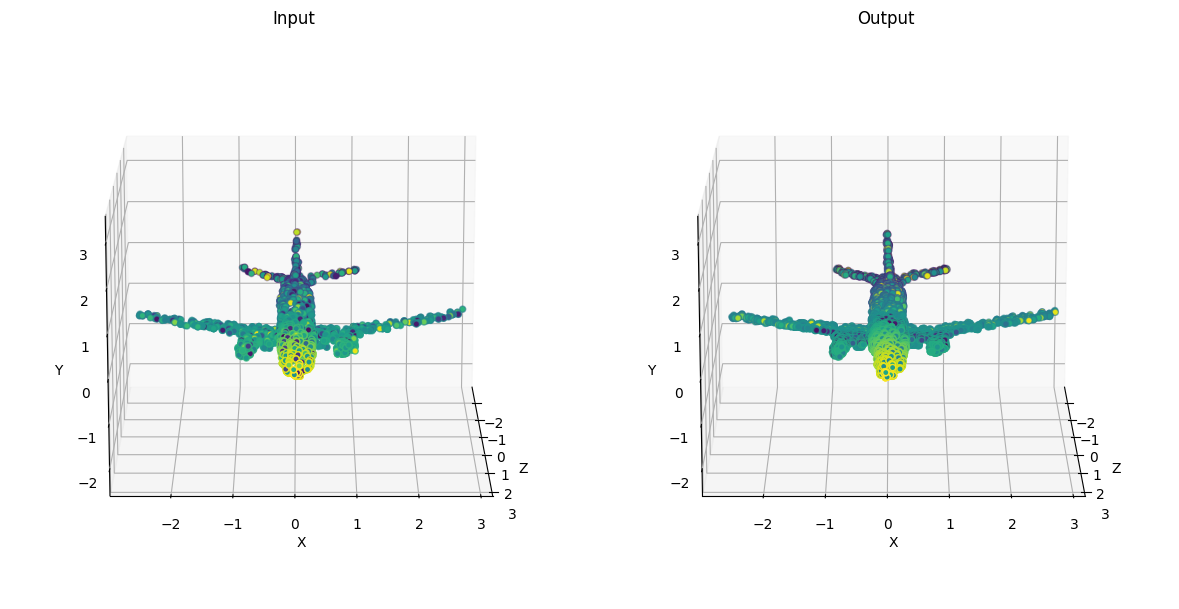

In [94]:
INDEX = 49
input_pc = pvd_output_pcs[INDEX, ...].detach()
output_pc = output_pcs[INDEX, ...].detach()
print(input_pc.shape, output_pc.shape)

fig = visualize_pointcloud_eval(input_pc, output_pc, "Input", "Output")

In [55]:
chamfer_distance(input_pc.unsqueeze(0), output_pc.unsqueeze(0))

tensor(0.0040, device='cuda:0')

In [56]:
EMD_loss(input_pc.unsqueeze(0), output_pc.unsqueeze(0))

tensor(0.1238, device='cuda:0')

In [57]:
get_repulsion_loss4(output_pc.unsqueeze(0))

tensor(0.0700, device='cuda:0')

In [95]:
from visuals.mitsuba_vis import render_mitsuba
import matplotlib.pyplot as plt

input_img = render_mitsuba(input_pc.cpu().numpy(), "./input.xml", fov=15, radius=0.01)
output_img = render_mitsuba(output_pc.cpu().numpy(), "./output.xml", fov=15, radius=0.01, n_points=NPOINTS)

Center: [-0.10352147  0.49859124 -0.08758342], Scale: 5.927061080932617
Center: [-0.10098457  0.491436   -0.1730982 ], Scale: 6.138104438781738


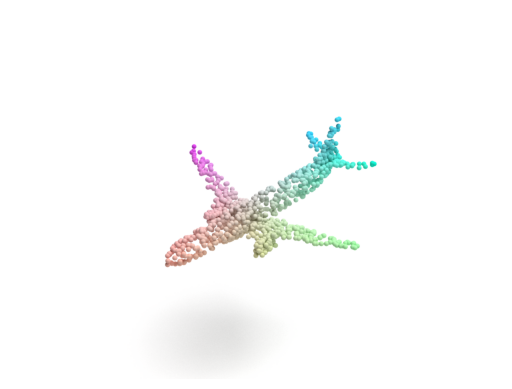

In [96]:
plt.axis("off")
plt.imshow(input_img ** (1.0 / 2.2)) # approximate sRGB tonemapping
plt.savefig("Input-Airplane-PVD.png", bbox_inches='tight', pad_inches=0, dpi=400)

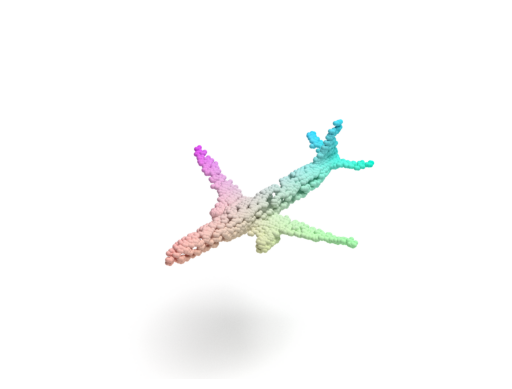

In [97]:
plt.axis("off")
plt.imshow(output_img ** (1.0 / 2.2)); # approximate sRGB tonemapping
plt.savefig("Output-Upsampled-Airplane-PVD.png", bbox_inches='tight', pad_inches=0, dpi=400)

# Let's try part segmentation and then refinement.

In [42]:
from models_adl4cv.pvcnn import PVCNNPartSeg

In [43]:
part_model = PVCNNPartSeg(num_classes=4, num_shapes=3, extra_feature_channels=0).to("cuda")
part_model.load_state_dict(torch.load("output-models/pvcnn-part-segmentation-noise/PVCNN-Part-Segmentation-Noise-e69.pth"))

<All keys matched successfully>

In [55]:
model.eval()

pvd_output = []
output_array = []

patched_input = []
patched_refined = []

with torch.no_grad():
    for batch in tqdm(dataloader_pvd):
        input = batch["test_points"].to("cuda")
        pvd_output.append(input)

        # Let's segment the input into parts and extract the part assignment.
        input_seg = part_model(input.transpose(1,2)).transpose(1,2).data.max(2)[1]
        
        output_batch = []

        for (sample, seg) in zip(input, input_seg):
            output_tensor = []

            for i in range(seg.max() + 1):
                part_input = sample[seg==i, :]
                
                # Patched input
                patched_input.append(part_input)

                output = model(part_input.unsqueeze(0).transpose(1,2))
                output = output.squeeze().transpose(0,1)

                #Refined patch
                patched_refined.append(output)

                output_tensor.append(output)

            output_tensor = torch.cat(output_tensor)
            output_batch.append(output_tensor.unsqueeze(0))
        
        output_batch = torch.cat(output_batch)
        output_array.append(output_batch)

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:20<00:00,  1.01s/it]


In [56]:
input_pcs = torch.stack(input_array).view(400, NPOINTS, 3)
pvd_output_pcs = torch.stack(pvd_output).view(400, NPOINTS // 2, 3)
output_pcs = torch.stack(output_array).view(400, NPOINTS, 3)
input_pcs.shape, output_pcs.shape, pvd_output_pcs.shape

(torch.Size([400, 4096, 3]),
 torch.Size([400, 4096, 3]),
 torch.Size([400, 2048, 3]))

torch.Size([2048, 3]) torch.Size([4096, 3])


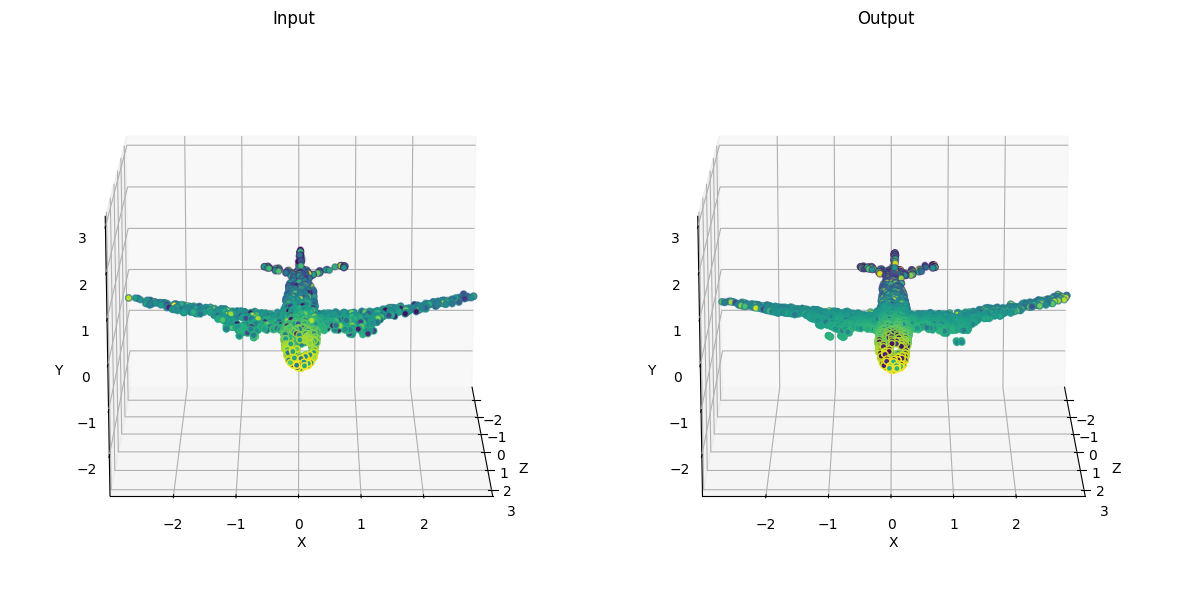

In [102]:
INDEX = 10
input_pc = pvd_output_pcs[INDEX, ...].detach()
output_pc = output_pcs[INDEX, ...].detach()
print(input_pc.shape, output_pc.shape)

fig = visualize_pointcloud_eval(input_pc, output_pc, "Input", "Output")

torch.Size([632, 3]) torch.Size([1264, 3])


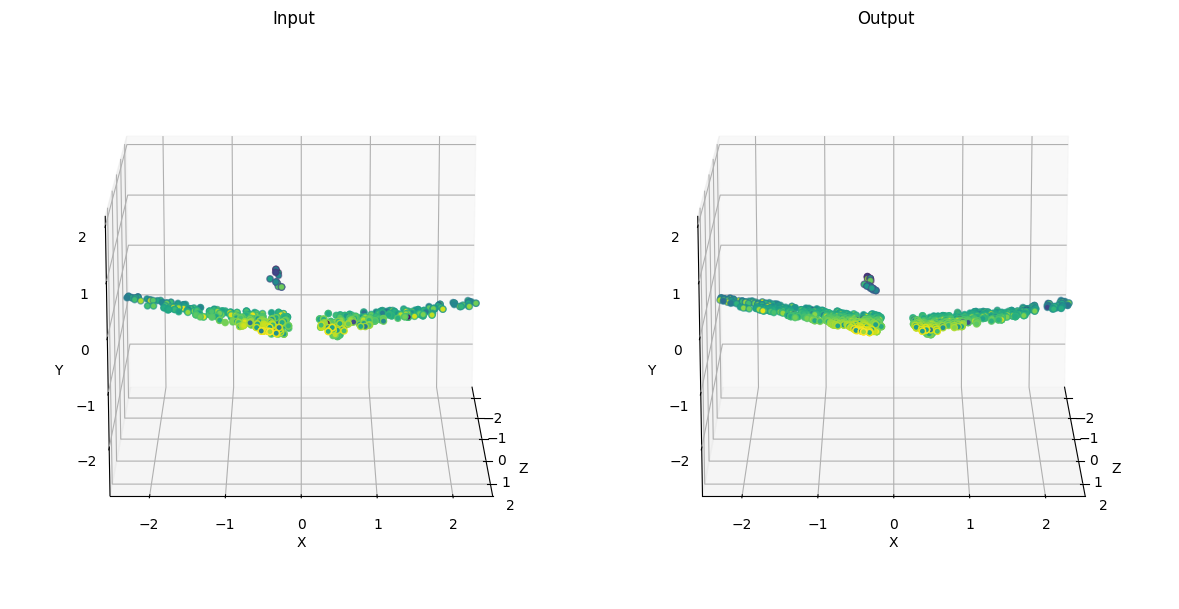

In [79]:
INDEX = 13
input_pc = patched_input[INDEX].detach()
output_pc = patched_refined[INDEX].detach()
print(input_pc.shape, output_pc.shape)

fig = visualize_pointcloud_eval(input_pc, output_pc, "Input", "Output")

In [103]:
from visuals.mitsuba_vis import render_mitsuba
import matplotlib.pyplot as plt

input_img = render_mitsuba(input_pc.cpu().numpy(), "./input.xml", fov=20, radius=0.015)
output_img = render_mitsuba(output_pc.cpu().numpy(), "./output.xml", fov=20, radius=0.015)

Center: [-0.04468906  0.15826222 -0.24793518], Scale: 5.874968528747559
Center: [-0.08632088  0.07072973 -0.23066807], Scale: 5.815140247344971


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


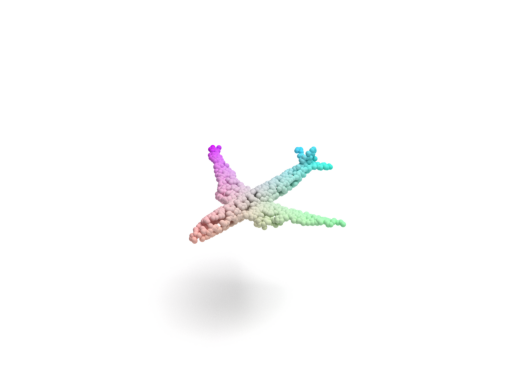

In [104]:
plt.axis("off")
plt.imshow(input_img ** (1.0 / 2.2)) # approximate sRGB tonemapping
plt.savefig("Input-Chair-PVD.png", bbox_inches='tight', pad_inches=0, dpi=400)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


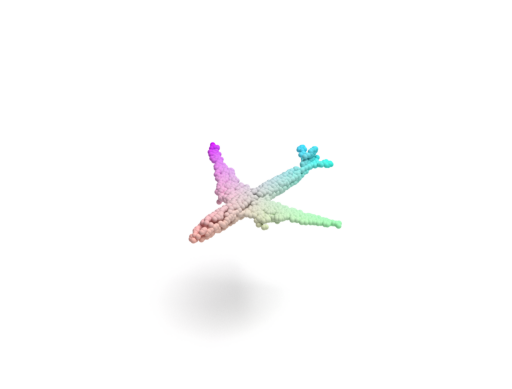

In [105]:
plt.axis("off")
plt.imshow(output_img ** (1.0 / 2.2)); # approximate sRGB tonemapping
plt.savefig("Output-Upsampled-Chair-PVD.png", bbox_inches='tight', pad_inches=0, dpi=400)

In [106]:
from metrics.evaluation_metrics import compute_all_metrics

results = compute_all_metrics(input_pcs, output_pcs, 100)
results = {k: (v.cpu().detach().item()
                if not isinstance(v, float) else v) for k, v in results.items()}

print(results)

100%|██████████| 400/400 [14:53<00:00,  2.24s/it]

{'lgan_mmd-CD': 0.06206703558564186, 'lgan_cov-CD': 0.33500000834465027, 'lgan_mmd_smp-CD': 0.019746804609894753, 'lgan_mmd-EMD': 0.5686208605766296, 'lgan_cov-EMD': 0.36500000953674316, 'lgan_mmd_smp-EMD': 0.29657360911369324, '1-NN-CD-acc_t': 0.8475000262260437, '1-NN-CD-acc_f': 0.9375, '1-NN-CD-acc': 0.8924999833106995, '1-NN-EMD-acc_t': 0.6299999952316284, '1-NN-EMD-acc_f': 0.8174999952316284, '1-NN-EMD-acc': 0.7237499952316284}


In [107]:
torch.save({"results": results} , "airplane_part_results.pth")

In [108]:
import torch
results = torch.load("./airplane_part_results.pth")
results

{'results': {'lgan_mmd-CD': 0.06206703558564186,
  'lgan_cov-CD': 0.33500000834465027,
  'lgan_mmd_smp-CD': 0.019746804609894753,
  'lgan_mmd-EMD': 0.5686208605766296,
  'lgan_cov-EMD': 0.36500000953674316,
  'lgan_mmd_smp-EMD': 0.29657360911369324,
  '1-NN-CD-acc_t': 0.8475000262260437,
  '1-NN-CD-acc_f': 0.9375,
  '1-NN-CD-acc': 0.8924999833106995,
  '1-NN-EMD-acc_t': 0.6299999952316284,
  '1-NN-EMD-acc_f': 0.8174999952316284,
  '1-NN-EMD-acc': 0.7237499952316284}}

In [ ]:
test = {
    'lgan_mmd-CD': 0.06206703558564186,
    'lgan_cov-CD': 0.33500000834465027,
    'lgan_mmd_smp-CD': 0.019746804609894753,
    'lgan_mmd-EMD': 0.5686208605766296,
    'lgan_cov-EMD': 0.36500000953674316,
    'lgan_mmd_smp-EMD': 0.29657360911369324,
    '1-NN-CD-acc_t': 0.8475000262260437,
    '1-NN-CD-acc_f': 0.9375,
    '1-NN-CD-acc': 0.8924999833106995,
    '1-NN-EMD-acc_t': 0.6299999952316284,
    '1-NN-EMD-acc_f': 0.8174999952316284,
    '1-NN-EMD-acc': 0.7237499952316284
}

# 1-NNA-CD 89.25%
# 1-NNA-EMD 72.37%